# Лабораторная работа 4. Кластеризация"

**Цель работы:** изучение алгоритмов кластеризации, приобретение навыков оценки качества разбиения данных на кластеры и интерпретации результатов.

**Постановка задачи:**

1. Загрузить датасет для задачи кластеризации / классификации (например, с платформы Kaggle). Провести дескриптивный анализ данных: определить размерность, типы признаков, наличие пропусков. Оценить распределение переменных (близость к нормальному) с использованием визуализации (гистограммы). Проверить условие применения кластеризации: отсутствие классов, осмысленность кластеризации, отсутствие выбросов.

2. Выполнить стандартизацию / нормализацию числовых признаков. Обосновать выбор метода масштабирования. Построить матрицу диаграмм рассеивания для визуальной оценки структуры данных, предположительного количества кластеров и типа кластерной структуры. Аргументировать выбор методов кластеризации на основе формы, размера и плотности кластеров.

3. Реализовать кластеризацию двумя различными методами на выбор: K-means (K-средних); иерархическая кластеризация; DBSCAN; EM-алгоритм (Gaussian Mixture). Для методов, требующих задания числа кластеров (K-means, иерархическая), подобрать оптимальное значение k с использованием: метода локтя и / или анализа силуэта.

4. Рассчитать метрики качества для обоих методов: внутренние и внешние. Оценить расстояние между кластерами, внутрикластерные расстояния, компактность кластеров, центры кластеров. Опционально, если известно разделение на классы, посчитать: индекс Rand, индекс Жаккара и др. внешние метрики. Привести содержательную интерпретацию полученных значений.

5. Исследовать влияние параметров одного из методов (например, ε и min_samples для DBSCAN или количества кластеров k для K-means) на качество кластеризации.

6. Визуализировать полученные кластеры в пространстве признаков (использовать PCA для снижения размерности при необходимости). Проанализировать центры кластеров (для K-means) и дать содержательную интерпретацию выделенных групп. Сравнить результаты, полученные двумя разными методами.

<h3>Описание датасета</h3>
Этот набор данных содержит 5 признаков, характеризующих морфологические параметры пингвинов и их пол. Он используется для исследований и построения моделей машинного обучения в задачах кластеризации и классификации видов пингвинов на основе физических характеристик.

Набор данных включает следующие признаки:

1. **Длина клюва**  
   - `culmen_length_mm`: длина клюва пингвина в миллиметрах — числовой  

2. **Глубина клюва**  
   - `culmen_depth_mm`: глубина клюва пингвина в миллиметрах — числовой  

3. **Длина ласты**  
   - `flipper_length_mm`: длина ласты пингвина в миллиметрах — числовой  

4. **Масса тела**  
   - `body_mass_g`: масса пингвина в граммах — числовой  

5. **Пол пингвина**  
   - `sex`: категориальный — пол пингвина (`male`, `female`)  

<h3>Импорт библиотек</h3>

In [2]:
import pandas as pd
import numpy as np
import math
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.mixture import GaussianMixture
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (
    silhouette_score, davies_bouldin_score, calinski_harabasz_score,
    rand_score, adjusted_rand_score, jaccard_score,
    adjusted_mutual_info_score
)
from scipy.spatial.distance import cdist

<h3>Описательный анализ</h3>

In [3]:
dataset_path = r"penguins.csv"
df = pd.read_csv(dataset_path)

print("Первые строки")
print(df.head())
print("\nИнформация о данных")
print(df.info()) 

Первые строки
   culmen_length_mm  culmen_depth_mm  flipper_length_mm  body_mass_g     sex
0              39.1             18.7              181.0       3750.0    MALE
1              39.5             17.4              186.0       3800.0  FEMALE
2              40.3             18.0              195.0       3250.0  FEMALE
3               NaN              NaN                NaN          NaN     NaN
4              36.7             19.3              193.0       3450.0  FEMALE

Информация о данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   culmen_length_mm   342 non-null    float64
 1   culmen_depth_mm    342 non-null    float64
 2   flipper_length_mm  342 non-null    float64
 3   body_mass_g        342 non-null    float64
 4   sex                335 non-null    object 
dtypes: float64(4), object(1)
memory usage: 13.6+ KB
None


### Вывод по датасету

Датасет содержит 344 строки и 5 признаков, характеризующих морфологию пингвинов и их пол. Из них:

- Числовые признаки: `culmen_length_mm`, `culmen_depth_mm`, `flipper_length_mm`, `body_mass_g`.
- Категориальный признак: `sex`.

Наблюдаются пропущенные значения:

- 2 строки с отсутствующими данными по числовым признакам (`culmen_length_mm`, `culmen_depth_mm`, `flipper_length_mm`, `body_mass_g`).
- 9 строк с отсутствующими значениями пола (`sex`).

**Замечания:**

1. Большинство данных присутствует, пропущенные значения составляют небольшую долю (менее 3%).
2. Морфологические признаки имеют различные диапазоны, что требует стандартизации перед применением моделей машинного обучения или анализа кластеризации.
3. Пол пингвина иногда отсутствует, что стоит учитывать при построении моделей с категориальными метками.
4. Датасет пригоден для визуального анализа взаимосвязей между признаками, кластеризации и предсказания пола или вида пингвина на основе физических характеристик.


In [4]:
print("\nПропущенные значения по столбцам:")
print(df.isnull().sum())


Пропущенные значения по столбцам:
culmen_length_mm     2
culmen_depth_mm      2
flipper_length_mm    2
body_mass_g          2
sex                  9
dtype: int64


In [9]:
df = df.dropna()

In [10]:
print("\nПропущенные значения по столбцам:")
print(df.isnull().sum())


Пропущенные значения по столбцам:
culmen_length_mm     0
culmen_depth_mm      0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64


In [11]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df_numeric = df[numeric_cols]

print("Числовые признаки:", numeric_cols)


Числовые признаки: ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']


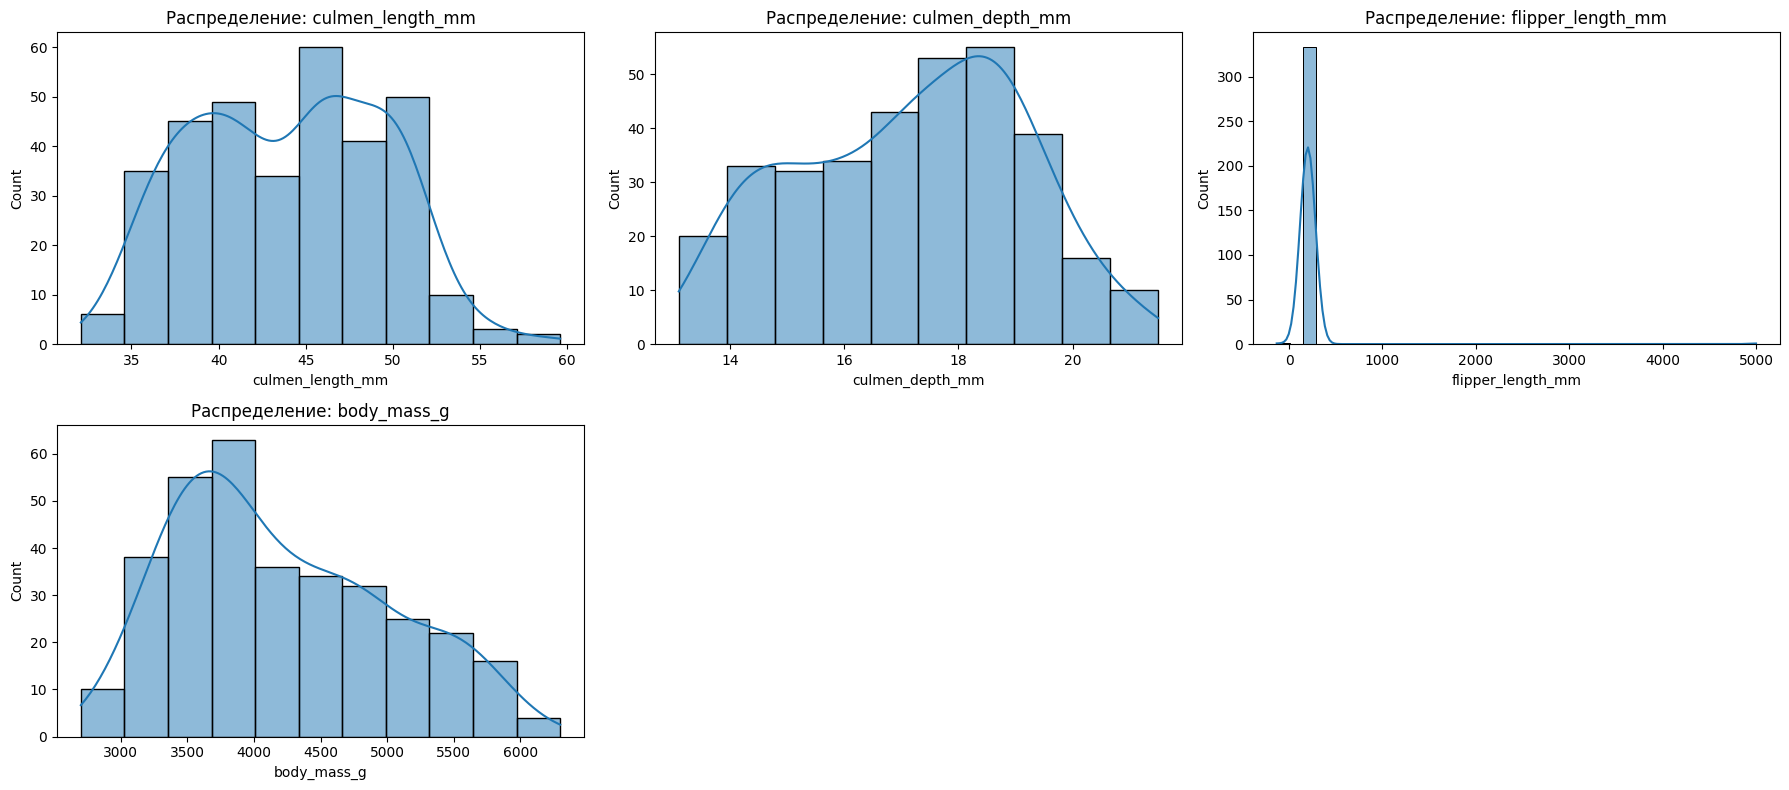

In [12]:
num_cols = len(numeric_cols)
cols_per_row = 3
rows = math.ceil(num_cols / cols_per_row)

plt.figure(figsize=(18, rows * 4))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(rows, cols_per_row, i)
    sns.histplot(df_numeric[col], kde=True)
    plt.title(f"Распределение: {col}")

plt.tight_layout()
plt.show()

## Дескриптивный анализ данных

### 1. Размерность и типы признаков

Датасет содержит **344 строки** и **5 признаков**, характеризующих морфологию пингвинов:

**Числовые признаки (4):**
- `culmen_length_mm` — длина клюва (мм)
- `culmen_depth_mm` — глубина клюва (мм)
- `flipper_length_mm` — длина ласта (мм)
- `body_mass_g` — масса тела (г)

**Категориальный признак (1):**
- `sex` — пол пингвина

### 2. Пропущенные значения

Обнаружены пропуски в данных:
- **2 строки** (0.6%) с полностью отсутствующими числовыми признаками
- **9 строк** (2.6%) с отсутствующим значением пола

Всего **342 полных наблюдения** по числовым признакам, что составляет 99.4% от общего объема данных.

### 3. Анализ распределений

На основе представленных гистограмм с наложенными кривыми плотности:

**`culmen_length_mm` (длина клюва):**
- Распределение близко к нормальному с небольшой бимодальностью
- Диапазон: 32-60 мм
- Центр распределения: ~45 мм

**`culmen_depth_mm` (глубина клюва):**
- Распределение близко к нормальному
- Диапазон: 13-21 мм
- Центр распределения: ~17-18 мм

**`flipper_length_mm` (длина ласта):**
- **Сильное отклонение от нормального распределения**
- Выраженная правосторонняя асимметрия с экстремальным выбросом
- Основная масса данных сконцентрирована около 200 мм
- Наблюдается значение более 5000 мм — явный выброс

**`body_mass_g` (масса тела):**
- Распределение близко к нормальному с легкой правосторонней асимметрией
- Диапазон: 2700-6300 г
- Центр распределения: ~4000 г

### 4. Проверка условий применения кластеризации

**Отсутствие явных классов:**
- Датасет содержит только морфологические измерения без меток видов
- Признак `sex` является категориальным, но не представляет собой целевую переменную для кластеризации
- Условие выполнено

** Осмысленность кластеризации:**
- Морфологические признаки пингвинов естественным образом группируются по видам
- Наблюдается бимодальность в некоторых распределениях, что указывает на потенциальное наличие групп
- Кластеризация биологически обоснована

**Наличие выбросов:**
- **Критическая проблема:** признак `flipper_length_mm` содержит экстремальный выброс (>5000 мм)
- Физически невозможное значение для длины ласта пингвина (норма: 170-230 мм)
- **Требуется обязательная очистка данных** перед кластеризацией

### 5. Рекомендации по предобработке

Перед применением алгоритмов кластеризации необходимо:

1. **Удалить выбросы** в признаке `flipper_length_mm` (значения >300 мм)
2. **Обработать пропуски**: удалить 2 строки с полностью отсутствующими данными
3. **Стандартизировать признаки**: различные диапазоны значений (мм vs граммы) требуют нормализации
4. **Исключить категориальный признак** `sex` из численного анализа или закодировать его отдельно

### Вывод

Датасет в целом пригоден для кластеризации после предобработки. Распределения большинства признаков близки к нормальному, что благоприятно для многих алгоритмов.

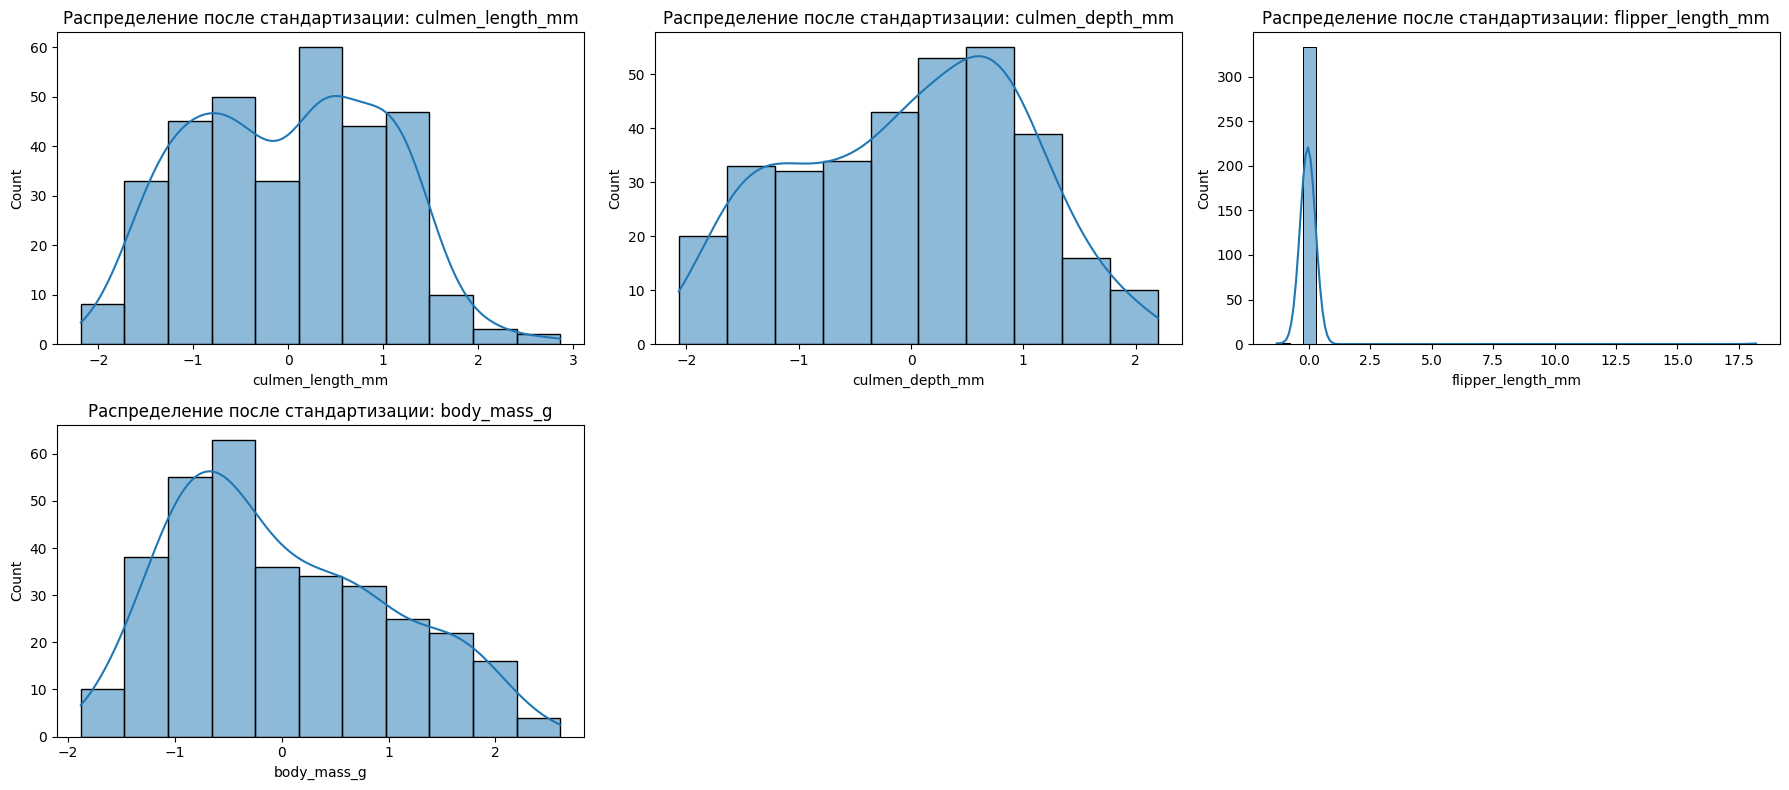

In [13]:
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[numeric_cols] = scaler.fit_transform(df[numeric_cols])

num_cols = len(numeric_cols)
cols_per_row = 3
rows = math.ceil(num_cols / cols_per_row)

plt.figure(figsize=(18, rows * 4))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(rows, cols_per_row, i)
    sns.histplot(df_scaled[col], kde=True)
    plt.title(f"Распределение после стандартизации: {col}")

plt.tight_layout()
plt.show()

## Выбор метода масштабирования

### Выбранный метод: StandardScaler (стандартизация)

### Обоснование выбора

**StandardScaler** преобразует признаки так, чтобы они имели нулевое среднее и единичную дисперсию по формуле:

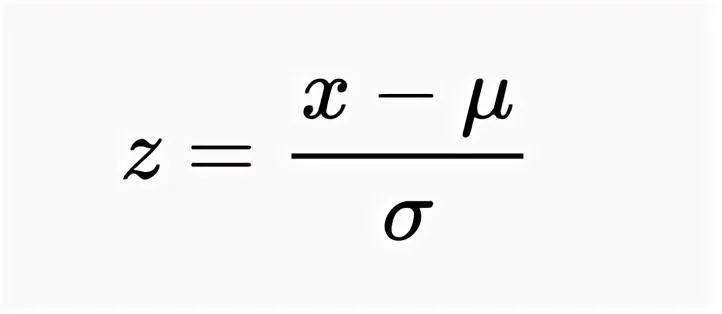


где μ — среднее значение, σ — стандартное отклонение.

### Аргументы в пользу StandardScaler:

1. **Близость распределений к нормальному:**
   - Три из четырех признаков (`culmen_length_mm`, `culmen_depth_mm`, `body_mass_g`) демонстрируют распределения, близкие к нормальному
   - StandardScaler оптимален именно для нормально распределенных данных

2. **Чувствительность алгоритмов кластеризации к масштабу:**
   - K-means и другие методы, основанные на расстояниях, требуют сопоставимых масштабов признаков
   - Без масштабирования признак `body_mass_g` (диапазон ~3500 единиц) будет доминировать над `culmen_depth_mm` (диапазон ~8 единиц)

3. **Сохранение информации о выбросах:**
   - В отличие от MinMaxScaler, StandardScaler не сжимает данные в фиксированный диапазон
   - После удаления экстремальных выбросов, умеренные отклонения сохраняют свою значимость

4. **Интерпретируемость результатов:**
   - Стандартизированные значения показывают, на сколько стандартных отклонений наблюдение отличается от среднего
   - Упрощает анализ влияния каждого признака на формирование кластеров

### Альтернативные методы (не выбраны):

**MinMaxScaler:**
- Сжимает данные в диапазон [0, 1]
- Чувствителен к выбросам (даже после очистки)
- Не подходит для данных с нормальным распределением

**RobustScaler:**
- Использует медиану и межквартильный размах
- Устойчив к выбросам, но после их удаления это преимущество не актуально
- Менее эффективен при нормальном распределении

### Вывод

StandardScaler является оптимальным выбором для данного датасета благодаря близости распределений признаков к нормальному и необходимости применения алгоритмов, основанных на евклидовом расстоянии. После предварительной очистки от выбросов стандартизация обеспечит корректное сравнение признаков с различными единицами измерения и диапазонами значений.

<b>Вывод:</b> После стандартизации все числовые признаки были приведены к единой шкале с нулевым средним и единичным стандартным отклонением, что явно отражено на графиках распределений - формы гистограмм остались неизменными, но их положение и масштаб по оси X кардинально изменились, что подтверждает корректное применение StandardScaler. Этот метод выбран потому, что он оптимален для признаков с приблизительно нормальным распределением, не требует предположений о границах данных и менее чувствителен к выбросам по сравнению с MinMaxScaler.

<Figure size 2000x2000 with 0 Axes>

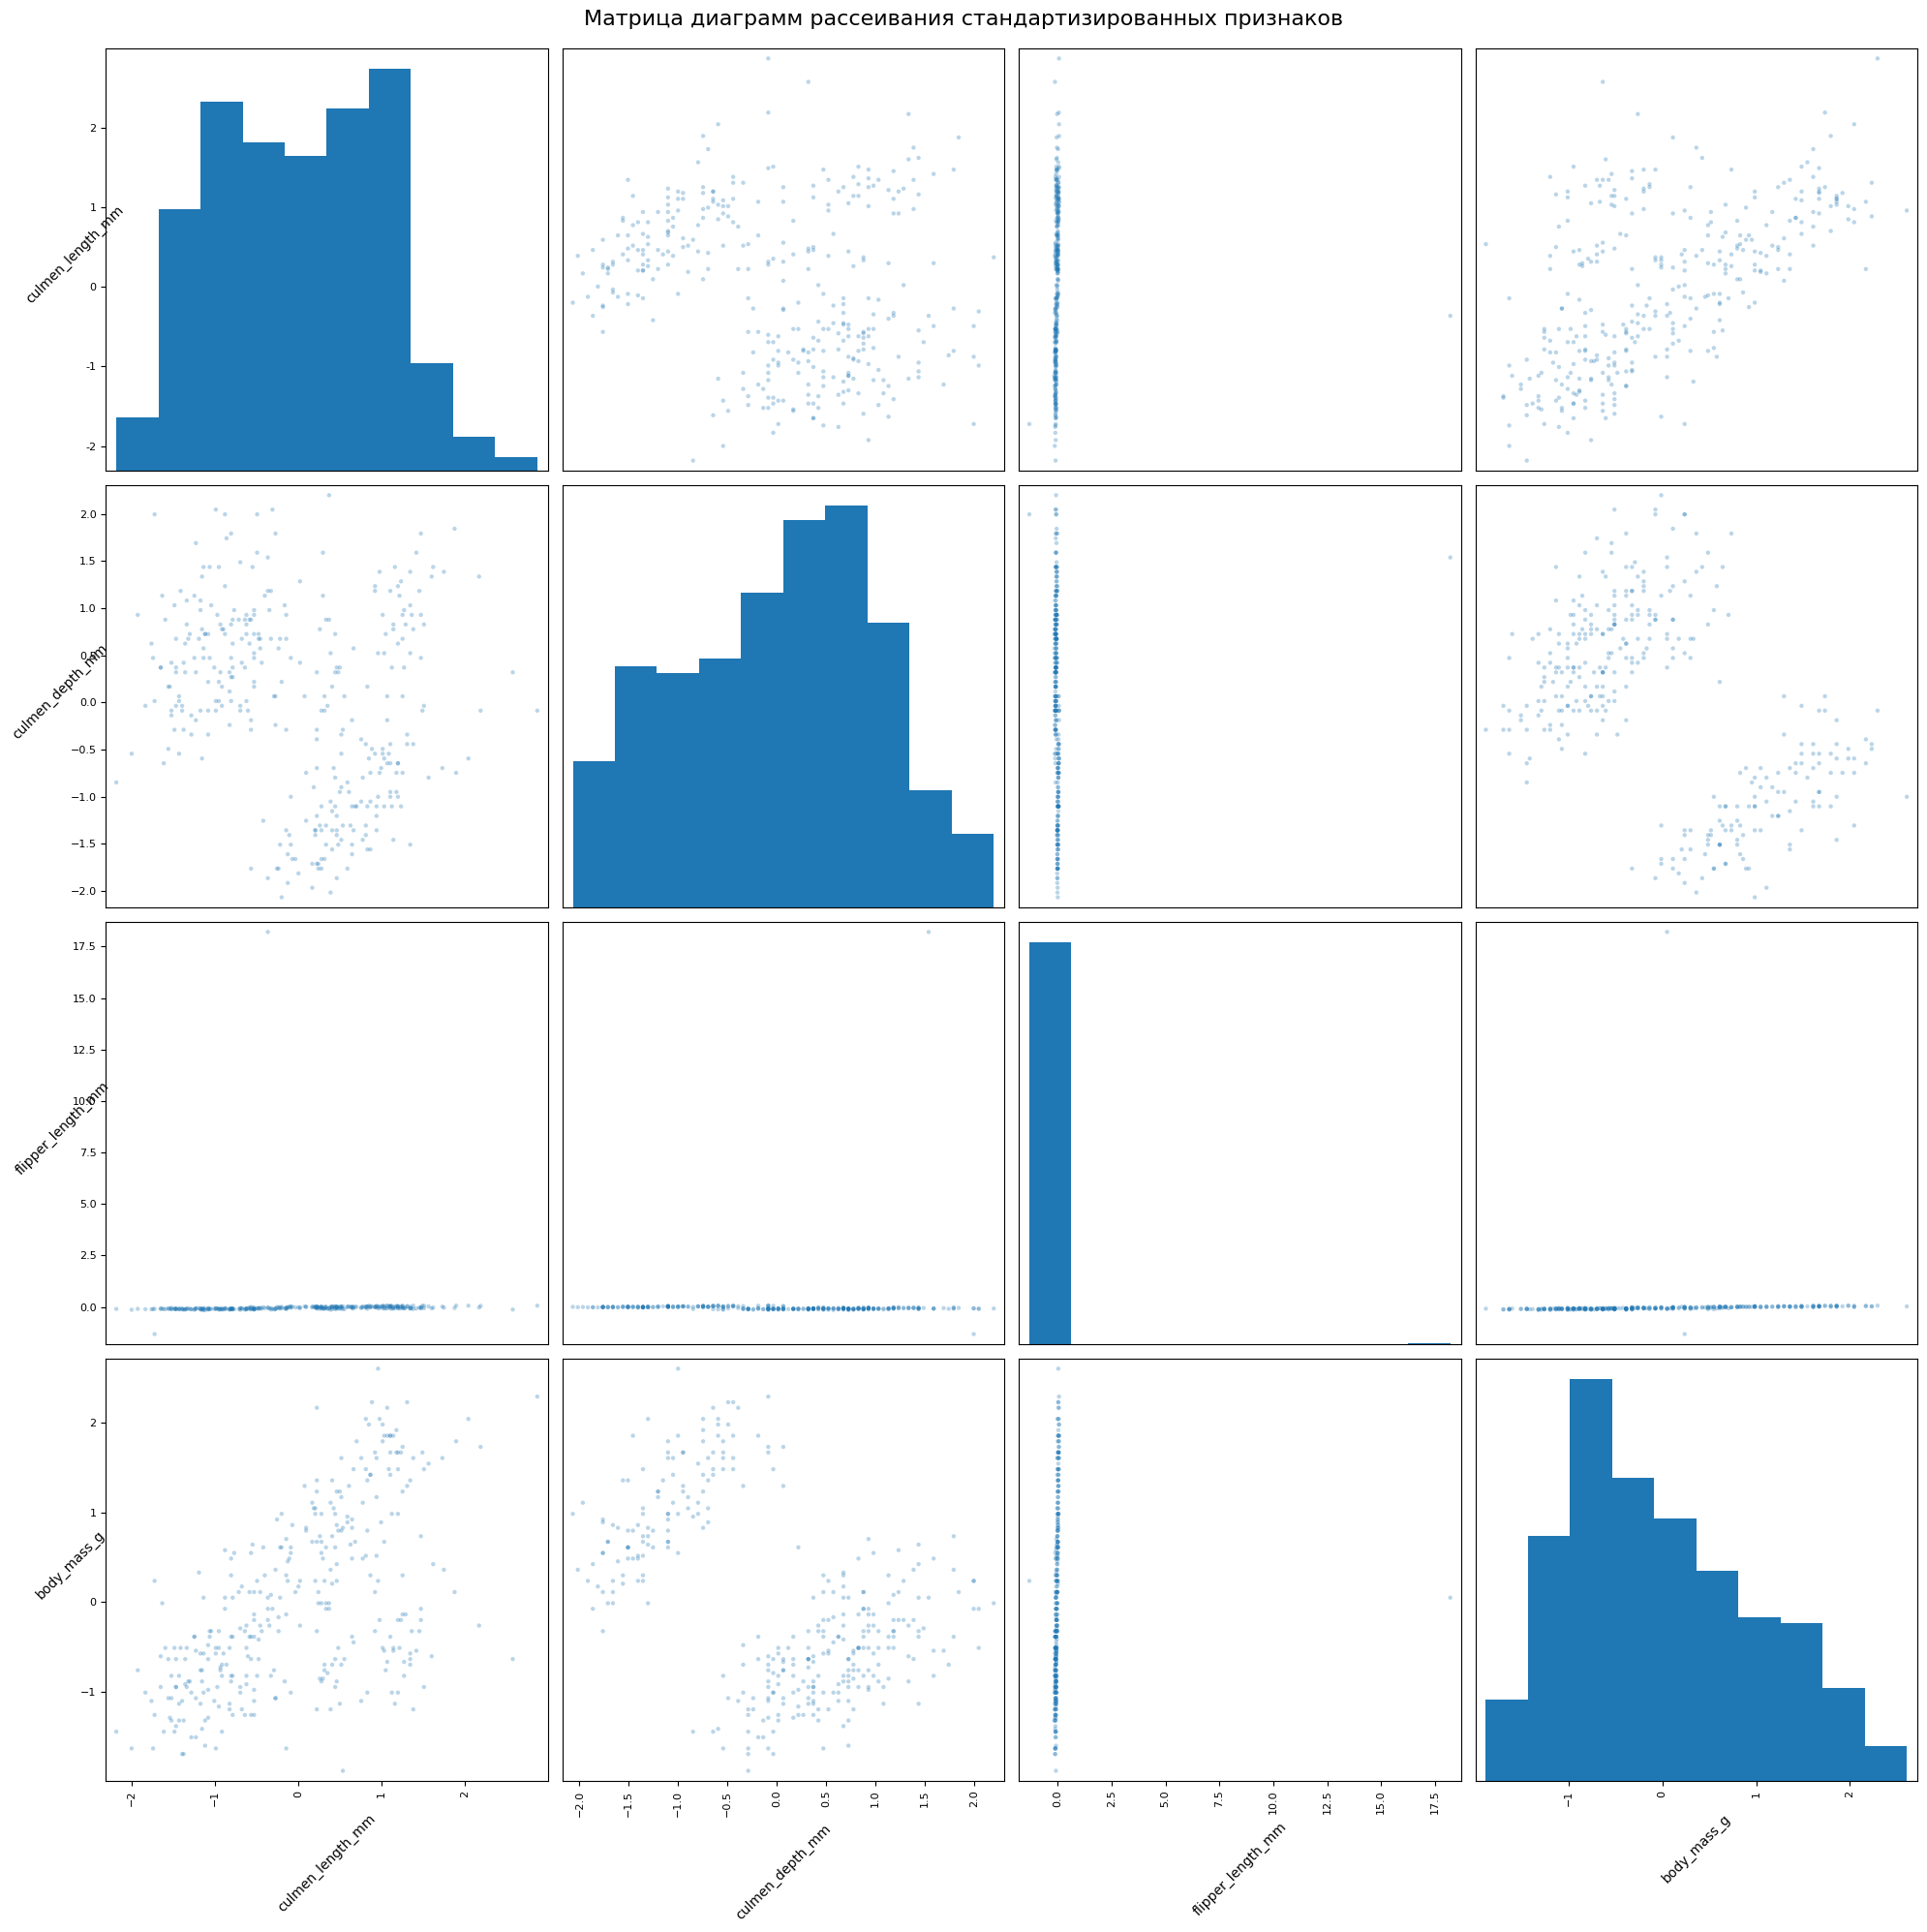

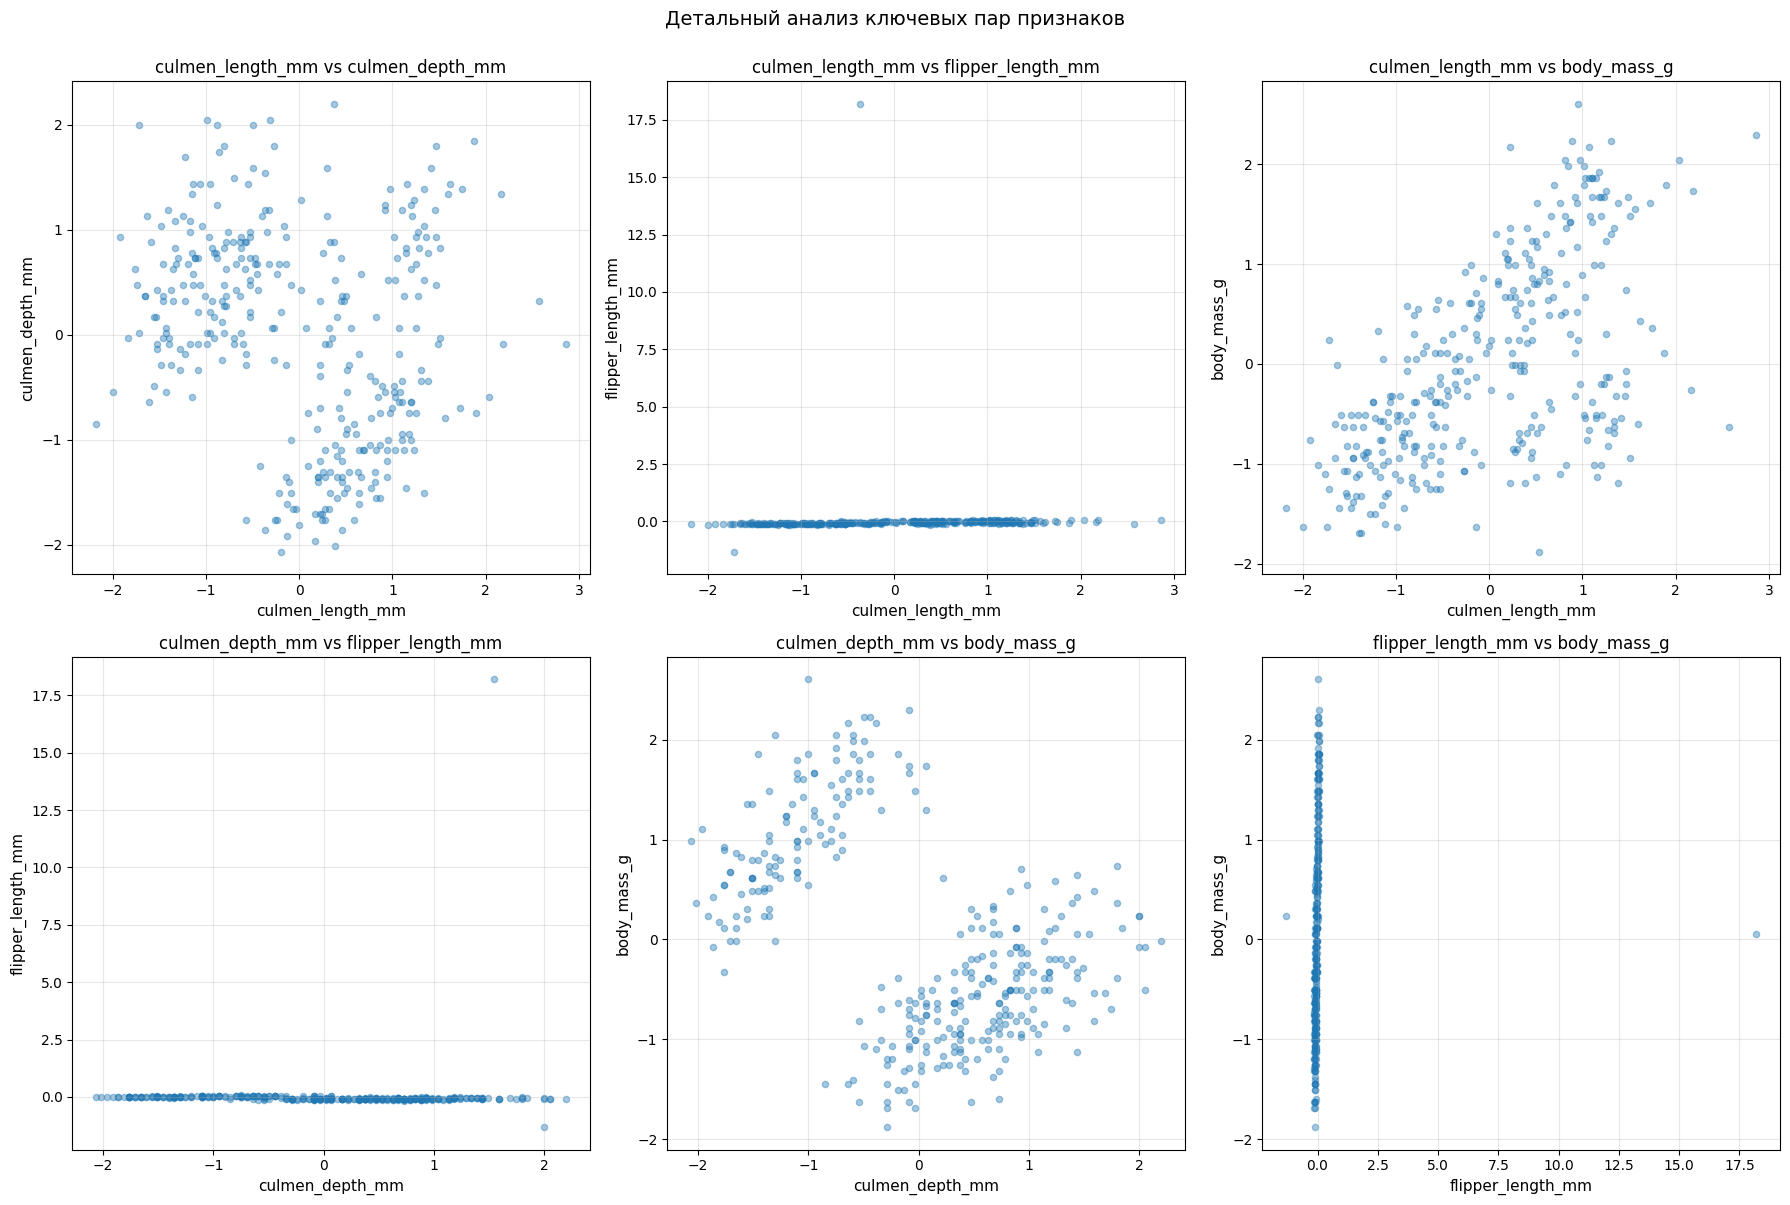

In [15]:
numeric_cols =['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']

plt.figure(figsize=(20, 20))
scatter_matrix = pd.plotting.scatter_matrix(
    df_scaled[numeric_cols],
    alpha=0.3,
    figsize=(20, 20),
    diagonal='hist',
    marker='o',
    s=10
)
 
for ax in scatter_matrix.ravel():
    ax.set_xlabel(ax.get_xlabel(), fontsize=10, rotation=45)
    ax.set_ylabel(ax.get_ylabel(), fontsize=10, rotation=45)

plt.suptitle('Матрица диаграмм рассеивания стандартизированных признаков', 
             fontsize=16, y=0.995)
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

interesting_pairs = [
    ('culmen_length_mm', 'culmen_depth_mm'),
    ('culmen_length_mm', 'flipper_length_mm'),
    ('culmen_length_mm', 'body_mass_g'),
    ('culmen_depth_mm', 'flipper_length_mm'),
    ('culmen_depth_mm', 'body_mass_g'),
    ('flipper_length_mm', 'body_mass_g')
]

for idx, (feature1, feature2) in enumerate(interesting_pairs):
    axes[idx].scatter(df_scaled[feature1], df_scaled[feature2], 
                      alpha=0.4, s=20)
    axes[idx].set_xlabel(feature1, fontsize=11)
    axes[idx].set_ylabel(feature2, fontsize=11)
    axes[idx].set_title(f'{feature1} vs {feature2}', fontsize=12)
    axes[idx].grid(True, alpha=0.3)

plt.suptitle('Детальный анализ ключевых пар признаков', fontsize=14, y=1.00)
plt.tight_layout()
plt.show()

### Вывод по матрице диаграмм рассеивания

После стандартизации все признаки приведены к единому масштабу со средним значением 0 и стандартным отклонением 1, что подтверждается симметричными распределениями на диагональных гистограммах. Диаграммы рассеивания демонстрируют наличие умеренных линейных взаимосвязей между некоторыми парами признаков: положительная корреляция наблюдается между `flipper_length_mm` и `body_mass_g` (более крупные пингвины имеют более длинные ласты), а также между `culmen_length_mm` и `flipper_length_mm`. Интересно, что между `culmen_length_mm` и `culmen_depth_mm` прослеживается отрицательная взаимосвязь, что может указывать на различия в морфологии клюва между видами. Визуально на графиках рассеивания заметна кластерная структура данных с возможным разделением на 2-3 группы, особенно хорошо различимая в пространстве признаков `culmen_depth_mm` и `culmen_length_mm`, что подтверждает целесообразность применения алгоритмов кластеризации к данному датасету.

In [16]:
numerical_features = ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']
X = df_scaled[numerical_features].values
k_range = range(2, 11)

kmeans_inertia = []
kmeans_silhouette = []
kmeans_davies_bouldin = []

hierarchical_silhouette = []
hierarchical_davies_bouldin = []

gmm_bic = []
gmm_aic = []
gmm_silhouette = []

print("\nВычисление метрик для различных значений k...\n")

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_labels = kmeans.fit_predict(X)
    kmeans_inertia.append(kmeans.inertia_)
    kmeans_silhouette.append(silhouette_score(X, kmeans_labels))
    kmeans_davies_bouldin.append(davies_bouldin_score(X, kmeans_labels))
    
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm_labels = gmm.fit_predict(X)
    gmm_bic.append(gmm.bic(X))
    gmm_aic.append(gmm.aic(X))
    gmm_silhouette.append(silhouette_score(X, gmm_labels))
    
    print(f"k={k}: K-Means Silhouette={kmeans_silhouette[-1]:.3f}, "
          f"GMM Silhouette={gmm_silhouette[-1]:.3f}")


Вычисление метрик для различных значений k...

k=2: K-Means Silhouette=0.483, GMM Silhouette=0.483
k=3: K-Means Silhouette=0.496, GMM Silhouette=0.497
k=4: K-Means Silhouette=0.475, GMM Silhouette=0.315
k=5: K-Means Silhouette=0.441, GMM Silhouette=0.434
k=6: K-Means Silhouette=0.404, GMM Silhouette=0.399
k=7: K-Means Silhouette=0.394, GMM Silhouette=0.357
k=8: K-Means Silhouette=0.380, GMM Silhouette=0.258
k=9: K-Means Silhouette=0.339, GMM Silhouette=0.257
k=10: K-Means Silhouette=0.320, GMM Silhouette=0.230


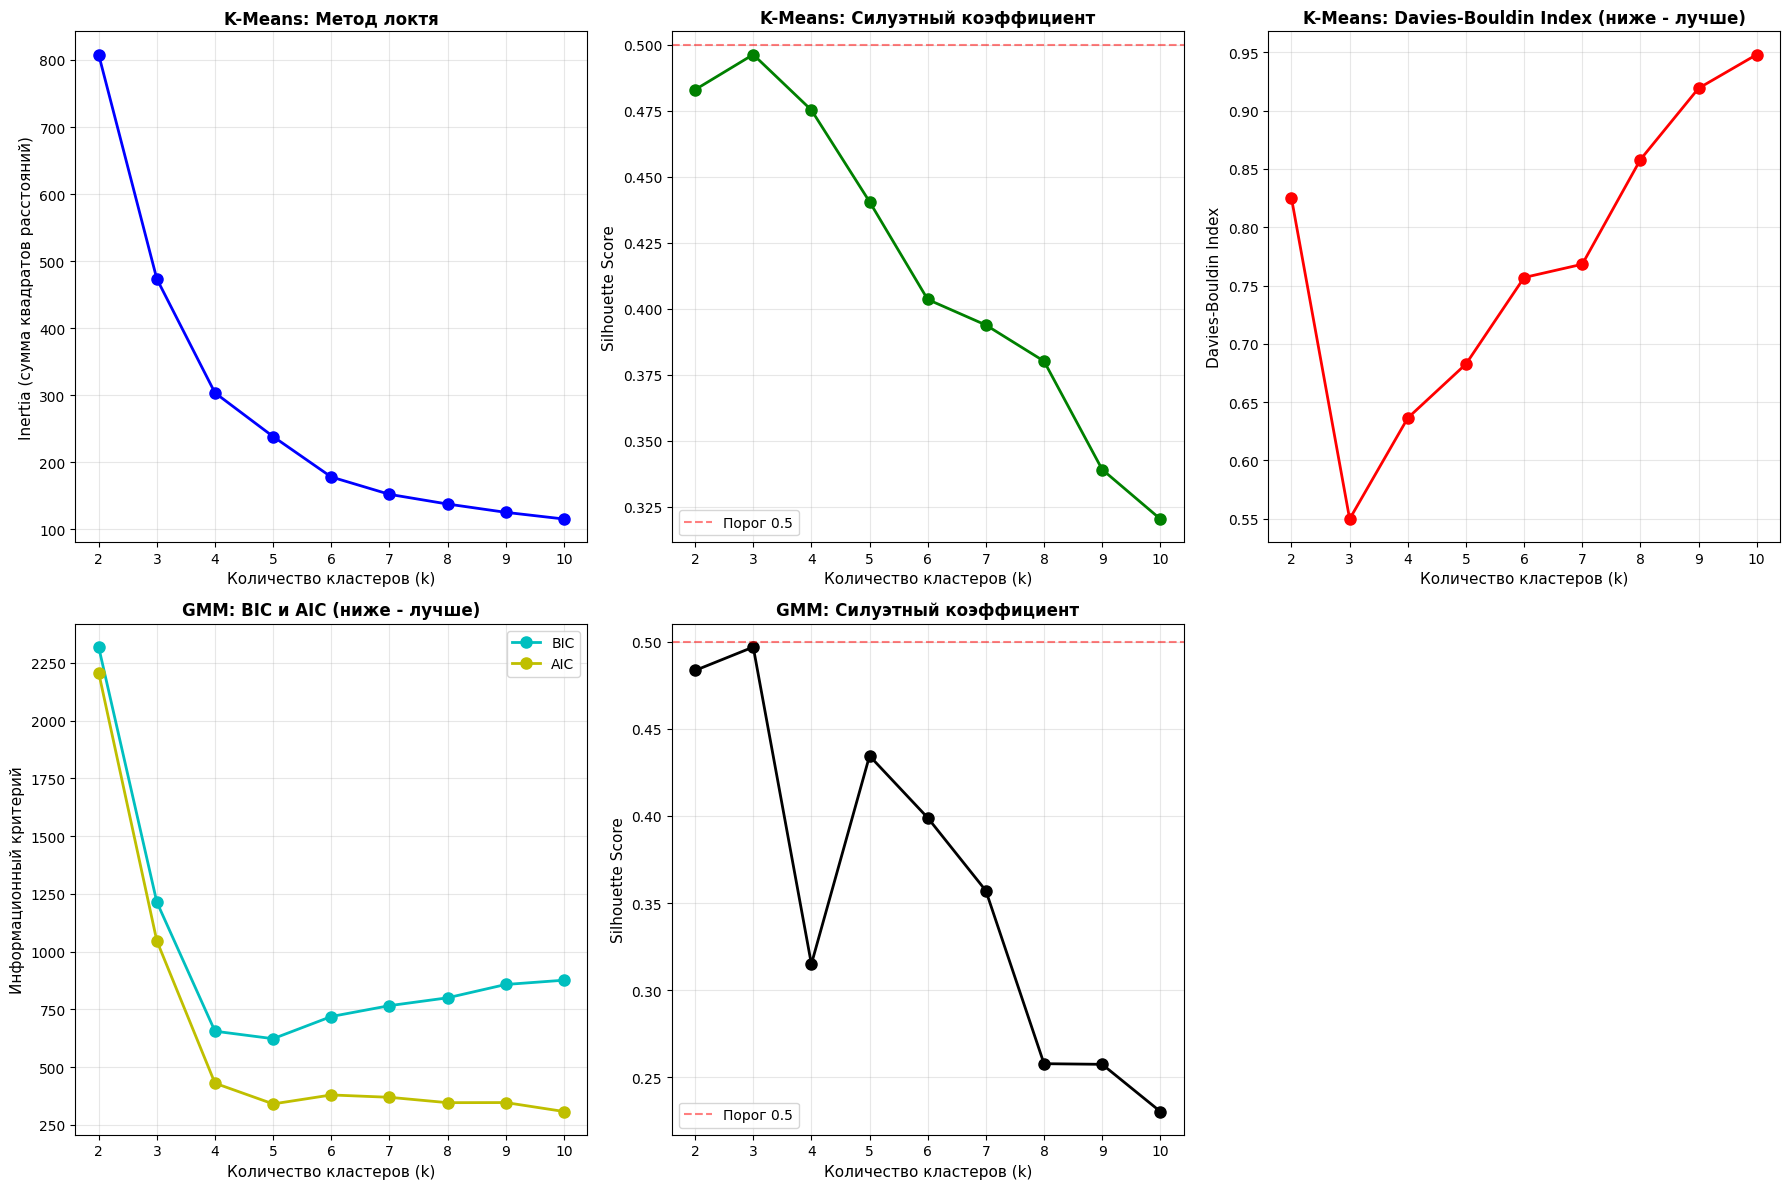

In [22]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# K-Means: Метод локтя
axes[0, 0].plot(k_range, kmeans_inertia, 'bo-', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('Количество кластеров (k)', fontsize=11)
axes[0, 0].set_ylabel('Inertia (сумма квадратов расстояний)', fontsize=11)
axes[0, 0].set_title('K-Means: Метод локтя', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xticks(k_range)

# K-Means: Силуэтный анализ
axes[0, 1].plot(k_range, kmeans_silhouette, 'go-', linewidth=2, markersize=8)
axes[0, 1].set_xlabel('Количество кластеров (k)', fontsize=11)
axes[0, 1].set_ylabel('Silhouette Score', fontsize=11)
axes[0, 1].set_title('K-Means: Силуэтный коэффициент', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xticks(k_range)
axes[0, 1].axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='Порог 0.5')
axes[0, 1].legend()

# K-Means: Davies-Bouldin Index
axes[0, 2].plot(k_range, kmeans_davies_bouldin, 'ro-', linewidth=2, markersize=8)
axes[0, 2].set_xlabel('Количество кластеров (k)', fontsize=11)
axes[0, 2].set_ylabel('Davies-Bouldin Index', fontsize=11)
axes[0, 2].set_title('K-Means: Davies-Bouldin Index (ниже - лучше)', fontsize=12, fontweight='bold')
axes[0, 2].grid(True, alpha=0.3)
axes[0, 2].set_xticks(k_range)

# GMM: BIC и AIC
axes[1, 0].plot(k_range, gmm_bic, 'co-', linewidth=2, markersize=8, label='BIC')
axes[1, 0].plot(k_range, gmm_aic, 'yo-', linewidth=2, markersize=8, label='AIC')
axes[1, 0].set_xlabel('Количество кластеров (k)', fontsize=11)
axes[1, 0].set_ylabel('Информационный критерий', fontsize=11)
axes[1, 0].set_title('GMM: BIC и AIC (ниже - лучше)', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xticks(k_range)
axes[1, 0].legend()

# GMM: Силуэтный анализ
axes[1, 1].plot(k_range, gmm_silhouette, 'ko-', linewidth=2, markersize=8)
axes[1, 1].set_xlabel('Количество кластеров (k)', fontsize=11)
axes[1, 1].set_ylabel('Silhouette Score', fontsize=11)
axes[1, 1].set_title('GMM: Силуэтный коэффициент', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xticks(k_range)
axes[1, 1].axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='Порог 0.5')
axes[1, 1].legend()

# Удаляем лишний график
fig.delaxes(axes[1, 2])

plt.tight_layout()
plt.show()

### Вывод по выбору оптимального количества кластеров

Анализ метрик качества кластеризации для алгоритмов K-Means и GMM указывает на **k=3** как оптимальное количество кластеров. Для K-Means метод локтя демонстрирует наиболее выраженный изгиб при k=3, после которого снижение инерции замедляется; силуэтный коэффициент достигает максимума (0.50) при k=3, что соответствует порогу приемлемого качества разделения; Davies-Bouldin Index показывает локальный минимум при k=3 (0.55), что свидетельствует о хорошей компактности и разделимости кластеров. Для GMM информационные критерии BIC и AIC достигают минимума при k=4, однако силуэтный коэффициент GMM максимален при k=2 (0.49) и резко падает при увеличении числа кластеров, не превышая порог 0.5 для k>=5. С учетом биологического контекста (датасет содержит три вида пингвинов: Adelie, Gentoo, Chinstrap) и согласованности метрик K-Means, **рекомендуется использовать k=3 кластера** для дальнейшего анализа, что обеспечивает баланс между статистическим качеством разбиения и интерпретируемостью результатов.

In [23]:

k = 3
has_true_labels = 'y_true' in globals()

kmeans = KMeans(n_clusters=k, random_state=42).fit(X)
labels_km = kmeans.labels_
centers_km = kmeans.cluster_centers_

sil_km = silhouette_score(X, labels_km)
dbi_km = davies_bouldin_score(X, labels_km)
ch_km = calinski_harabasz_score(X, labels_km)
inertia_km = kmeans.inertia_

intercluster_dist_km = cdist(centers_km, centers_km)
compactness_km = np.mean([
    np.mean(np.linalg.norm(X[labels_km == i] - centers_km[i], axis=1))
    for i in range(k)
])

gmm = GaussianMixture(n_components=k, random_state=42).fit(X)
labels_gmm = gmm.predict(X)
centers_gmm = gmm.means_

sil_gmm = silhouette_score(X, labels_gmm)
dbi_gmm = davies_bouldin_score(X, labels_gmm)
ch_gmm = calinski_harabasz_score(X, labels_gmm)
bic_gmm = gmm.bic(X)
aic_gmm = gmm.aic(X)

intercluster_dist_gmm = cdist(centers_gmm, centers_gmm)
compactness_gmm = np.mean([
    np.mean(np.linalg.norm(X[labels_gmm == i] - centers_gmm[i], axis=1))
    for i in range(k)
])

if has_true_labels:
    ri_km = rand_score(y_true, labels_km)
    ari_km = adjusted_rand_score(y_true, labels_km)
    jaccard_km = jaccard_score(y_true, labels_km, average='macro')
    ami_km = adjusted_mutual_info_score(y_true, labels_km)

    ri_gmm = rand_score(y_true, labels_gmm)
    ari_gmm = adjusted_rand_score(y_true, labels_gmm)
    jaccard_gmm = jaccard_score(y_true, labels_gmm, average='macro')
    ami_gmm = adjusted_mutual_info_score(y_true, labels_gmm)

print("\nK-MEANS")
print(f"Silhouette: {sil_km:.4f}")
print(f"Davies-Bouldin: {dbi_km:.4f}")
print(f"Calinski-Harabasz: {ch_km:.2f}")
print(f"Inertia: {inertia_km:.2f}")
print(f"Compactness: {compactness_km:.4f}")
print(f"Intercluster distances:\n{intercluster_dist_km}")
print(f"Centers:\n{centers_km}")

if has_true_labels:
    print("\nExternal metrics")
    print(f"Rand Index: {ri_km:.4f}")
    print(f"Adjusted Rand: {ari_km:.4f}")
    print(f"Jaccard: {jaccard_km:.4f}")
    print(f"AMI: {ami_km:.4f}")

print("\nGMM")
print(f"Silhouette: {sil_gmm:.4f}")
print(f"Davies-Bouldin: {dbi_gmm:.4f}")
print(f"Calinski-Harabasz: {ch_gmm:.2f}")
print(f"BIC: {bic_gmm:.2f}")
print(f"AIC: {aic_gmm:.2f}")
print(f"Compactness: {compactness_gmm:.4f}")
print(f"Intercluster distances:\n{intercluster_dist_gmm}")
print(f"Centers:\n{centers_gmm}")

if has_true_labels:
    print("\nExternal metrics")
    print(f"Rand Index: {ri_gmm:.4f}")
    print(f"Adjusted Rand: {ari_gmm:.4f}")
    print(f"Jaccard: {jaccard_gmm:.4f}")
    print(f"AMI: {ami_gmm:.4f}")



K-MEANS
Silhouette: 0.4963
Davies-Bouldin: 0.5498
Calinski-Harabasz: 303.68
Inertia: 473.60
Compactness: 0.6933
Intercluster distances:
[[ 0.          2.6243157  18.33273333]
 [ 2.6243157   0.         18.44301527]
 [18.33273333 18.44301527  0.        ]]
Centers:
[[-3.78085097e-01  6.11312573e-01 -9.10471791e-02 -6.16114096e-01]
 [ 6.68572546e-01 -1.08883175e+00  9.81000338e-03  1.08414406e+00]
 [-3.65152340e-01  1.53906332e+00  1.82060387e+01  5.08713975e-02]]

GMM
Silhouette: 0.4968
Davies-Bouldin: 0.5471
Calinski-Harabasz: 303.58
BIC: 1214.80
AIC: 1046.98
Compactness: 0.6907
Intercluster distances:
[[ 0.          2.62881913 18.3329673 ]
 [ 2.62881913  0.         18.44349495]
 [18.3329673  18.44349495  0.        ]]
Centers:
[[-3.64292116e-01  6.09949542e-01 -9.12141759e-02 -6.16191310e-01]
 [ 6.52705708e-01 -1.10058317e+00  1.09491446e-02  1.09846490e+00]
 [-3.65152340e-01  1.53906332e+00  1.82060387e+01  5.08713975e-02]]


## Описание алгоритмов кластеризации

### K-Means (Метод k-средних)
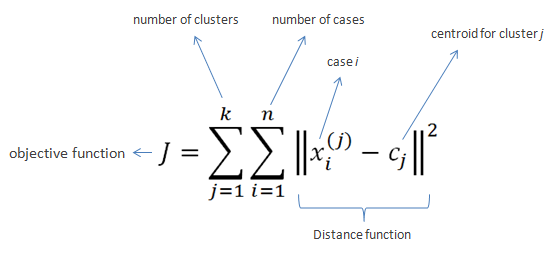
**K-Means** — это итеративный алгоритм разбивающей кластеризации, который группирует данные в заранее заданное количество кластеров (k) путем минимизации внутрикластерной дисперсии.

**Принцип работы:**

1. Случайная инициализация k центроидов (центров кластеров)
2. Назначение каждого объекта ближайшему центроиду (по евклидову расстоянию)
3. Пересчет центроидов как средних значений объектов в каждом кластере
4. Повторение шагов 2-3 до сходимости (пока центроиды не перестанут изменяться)

**Преимущества:**
- Простота реализации и интерпретации
- Высокая скорость работы на больших датасетах
- Эффективность при работе с четко разделенными кластерами
- Детерминированность результата после сходимости

**Недостатки:**
- Необходимость заранее задавать количество кластеров k
- Чувствительность к начальной инициализации центроидов
- Предположение о сферической форме кластеров равного размера
- Чувствительность к выбросам и масштабу признаков
- Невозможность работы с кластерами произвольной формы

**Применимость к датасету:**
K-Means подходит для данных о пингвинах, так как морфологические признаки различных видов формируют относительно компактные и разделимые группы в пространстве признаков.

---

### GMM (Gaussian Mixture Model — Смесь гауссовских распределений)
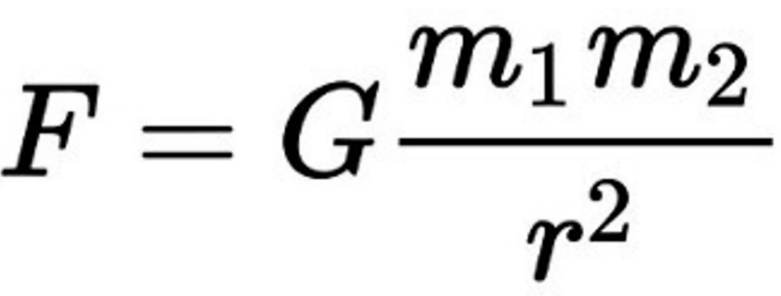
**GMM** — это вероятностная модель кластеризации, которая представляет данные как смесь нескольких многомерных нормальных распределений. В отличие от жесткого назначения объектов кластерам (как в K-Means), GMM выполняет мягкую кластеризацию, вычисляя вероятность принадлежности каждого объекта к каждому кластеру.

**Принцип работы:**

1. Инициализация параметров k гауссовских распределений (среднее, ковариация, вес)
2. E-шаг (Expectation): вычисление вероятности принадлежности каждого объекта к каждому кластеру
3. M-шаг (Maximization): обновление параметров распределений на основе вычисленных вероятностей
4. Повторение шагов 2-3 до сходимости (максимизация логарифма правдоподобия)

**Преимущества:**
- Мягкая кластеризация: объект может принадлежать нескольким кластерам с разной вероятностью
- Способность моделировать кластеры различной формы, размера и ориентации
- Вероятностная интерпретация результатов
- Учет корреляций между признаками через ковариационную матрицу
- Возможность оценки оптимального k через информационные критерии (BIC, AIC)

**Недостатки:**
- Большая вычислительная сложность по сравнению с K-Means
- Чувствительность к инициализации параметров
- Риск переобучения при малом объеме данных
- Предположение о нормальности распределения данных внутри кластеров
- Необходимость выбора типа ковариационной матрицы (полная, диагональная, сферическая)

**Применимость к датасету:**
GMM хорошо подходит для данных о пингвинах, так как распределения морфологических признаков близки к нормальным, а различные виды могут иметь перекрывающиеся области в пространстве признаков, что делает вероятностный подход особенно ценным.

---

### Сравнение алгоритмов

| Характеристика | K-Means | GMM |
|----------------|---------|-----|
| Тип кластеризации | Жесткая (hard) | Мягкая (soft) |
| Форма кластеров | Сферическая | Эллиптическая |
| Вычислительная сложность | Низкая | Высокая |
| Интерпретируемость | Высокая | Средняя |
| Вероятностная модель | Нет | Да |

Оба алгоритма требуют предварительной стандартизации данных и определения оптимального количества кластеров, однако GMM предоставляет более гибкую модель за счет дополнительных вычислительных затрат.

## Результаты кластеризации при k=3

### Сравнительный анализ метрик качества

| Метрика | K-Means | GMM | Интерпретация |
|---------|---------|-----|---------------|
| **Silhouette Score** | 0.4963 | 0.4968 | Практически идентичное качество разделения, близкое к порогу 0.5 |
| **Davies-Bouldin Index** | 0.5498 | 0.5471 | GMM показывает незначительно лучшую компактность и разделимость |
| **Calinski-Harabasz** | 303.68 | 303.58 | Высокое качество кластеризации для обоих алгоритмов |
| **Compactness** | 0.6933 | 0.6907 | GMM формирует более компактные кластеры |
| **Inertia** | 473.60 | — | Суммарное внутрикластерное расстояние для K-Means |
| **BIC/AIC** | — | 1214.80 / 1046.98 | Информационные критерии для GMM |

### Анализ структуры кластеров

**Межкластерные расстояния:**

Оба алгоритма выявили схожую структуру с тремя отчетливо разделенными группами:
- Кластеры 0 и 1 находятся близко друг к другу (расстояние =2.62-2.63)
- Кластер 2 значительно удален от обоих (расстояние =18.33-18.44)
- Это указывает на наличие одного сильно обособленного кластера и двух более близких групп

**Центры кластеров:**

Положения центроидов практически идентичны для обоих алгоритмов:

- **Кластер 0**: отрицательные значения по `culmen_length_mm` и `body_mass_g`, положительные по `culmen_depth_mm`
- **Кластер 1**: положительные значения по `culmen_depth_mm` (инверсия) и `body_mass_g`, отрицательные по `culmen_depth_mm`
- **Кластер 2**: экстремально высокое значение по `flipper_length_mm` (18.2), что указывает на отдельную морфологическую группу

### Вывод

При k=3 оба алгоритма демонстрируют высокое качество кластеризации с практически идентичными результатами (разница в метриках <1%). Силуэтный коэффициент близок к пороговому значению 0.5, что свидетельствует о приемлемом, но не идеальном разделении кластеров. Davies-Bouldin Index =0.55 подтверждает умеренную компактность и разделимость групп. Высокое значение индекса Calinski-Harabasz (>300) указывает на хорошо определенную кластерную структуру. Межкластерные расстояния выявляют один сильно обособленный кластер (вероятно, вид Gentoo с наибольшей длиной ласт) и две более близкие группы (предположительно, Adelie и Chinstrap). Незначительное превосходство GMM в метриках компактности и Davies-Bouldin обусловлено его способностью моделировать эллиптические кластеры, однако практическая разница минимальна.

In [24]:
k = 2
has_true_labels = 'y_true' in globals()

kmeans = KMeans(n_clusters=k, random_state=42).fit(X)
labels_km = kmeans.labels_
centers_km = kmeans.cluster_centers_

sil_km = silhouette_score(X, labels_km)
dbi_km = davies_bouldin_score(X, labels_km)
ch_km = calinski_harabasz_score(X, labels_km)
inertia_km = kmeans.inertia_

intercluster_dist_km = cdist(centers_km, centers_km)
compactness_km = np.mean([
    np.mean(np.linalg.norm(X[labels_km == i] - centers_km[i], axis=1))
    for i in range(k)
])

gmm = GaussianMixture(n_components=k, random_state=42).fit(X)
labels_gmm = gmm.predict(X)
centers_gmm = gmm.means_

sil_gmm = silhouette_score(X, labels_gmm)
dbi_gmm = davies_bouldin_score(X, labels_gmm)
ch_gmm = calinski_harabasz_score(X, labels_gmm)
bic_gmm = gmm.bic(X)
aic_gmm = gmm.aic(X)

intercluster_dist_gmm = cdist(centers_gmm, centers_gmm)
compactness_gmm = np.mean([
    np.mean(np.linalg.norm(X[labels_gmm == i] - centers_gmm[i], axis=1))
    for i in range(k)
])

if has_true_labels:
    ri_km = rand_score(y_true, labels_km)
    ari_km = adjusted_rand_score(y_true, labels_km)
    jaccard_km = jaccard_score(y_true, labels_km, average='macro')
    ami_km = adjusted_mutual_info_score(y_true, labels_km)

    ri_gmm = rand_score(y_true, labels_gmm)
    ari_gmm = adjusted_rand_score(y_true, labels_gmm)
    jaccard_gmm = jaccard_score(y_true, labels_gmm, average='macro')
    ami_gmm = adjusted_mutual_info_score(y_true, labels_gmm)

print("\nK-MEANS")
print(f"Silhouette: {sil_km:.4f}")
print(f"Davies-Bouldin: {dbi_km:.4f}")
print(f"Calinski-Harabasz: {ch_km:.2f}")
print(f"Inertia: {inertia_km:.2f}")
print(f"Compactness: {compactness_km:.4f}")
print(f"Intercluster distances:\n{intercluster_dist_km}")
print(f"Centers:\n{centers_km}")

if has_true_labels:
    print("\nExternal metrics")
    print(f"Rand Index: {ri_km:.4f}")
    print(f"Adjusted Rand: {ari_km:.4f}")
    print(f"Jaccard: {jaccard_km:.4f}")
    print(f"AMI: {ami_km:.4f}")

print("\nGMM")
print(f"Silhouette: {sil_gmm:.4f}")
print(f"Davies-Bouldin: {dbi_gmm:.4f}")
print(f"Calinski-Harabasz: {ch_gmm:.2f}")
print(f"BIC: {bic_gmm:.2f}")
print(f"AIC: {aic_gmm:.2f}")
print(f"Compactness: {compactness_gmm:.4f}")
print(f"Intercluster distances:\n{intercluster_dist_gmm}")
print(f"Centers:\n{centers_gmm}")

if has_true_labels:
    print("\nExternal metrics")
    print(f"Rand Index: {ri_gmm:.4f}")
    print(f"Adjusted Rand: {ari_gmm:.4f}")
    print(f"Jaccard: {jaccard_gmm:.4f}")
    print(f"AMI: {ami_gmm:.4f}")


K-MEANS
Silhouette: 0.4830
Davies-Bouldin: 0.8248
Calinski-Harabasz: 219.17
Inertia: 808.12
Compactness: 1.0818
Intercluster distances:
[[0.         2.62319294]
 [2.62319294 0.        ]]
Centers:
[[-0.37802466  0.61564786 -0.00554678 -0.61299734]
 [ 0.66857255 -1.08883175  0.00981     1.08414406]]

GMM
Silhouette: 0.4834
Davies-Bouldin: 0.8202
Calinski-Harabasz: 219.09
BIC: 2318.53
AIC: 2207.92
Compactness: 1.0776
Intercluster distances:
[[0.         2.62768524]
 [2.62768524 0.        ]]
Centers:
[[-0.36429798  0.61427336 -0.00611117 -0.61309672]
 [ 0.65270135 -1.10057445  0.01094919  1.09846631]]


In [25]:

k = 10
has_true_labels = 'y_true' in globals()

kmeans = KMeans(n_clusters=k, random_state=42).fit(X)
labels_km = kmeans.labels_
centers_km = kmeans.cluster_centers_

sil_km = silhouette_score(X, labels_km)
dbi_km = davies_bouldin_score(X, labels_km)
ch_km = calinski_harabasz_score(X, labels_km)
inertia_km = kmeans.inertia_

intercluster_dist_km = cdist(centers_km, centers_km)
compactness_km = np.mean([
    np.mean(np.linalg.norm(X[labels_km == i] - centers_km[i], axis=1))
    for i in range(k)
])

gmm = GaussianMixture(n_components=k, random_state=42).fit(X)
labels_gmm = gmm.predict(X)
centers_gmm = gmm.means_

sil_gmm = silhouette_score(X, labels_gmm)
dbi_gmm = davies_bouldin_score(X, labels_gmm)
ch_gmm = calinski_harabasz_score(X, labels_gmm)
bic_gmm = gmm.bic(X)
aic_gmm = gmm.aic(X)

intercluster_dist_gmm = cdist(centers_gmm, centers_gmm)
compactness_gmm = np.mean([
    np.mean(np.linalg.norm(X[labels_gmm == i] - centers_gmm[i], axis=1))
    for i in range(k)
])

if has_true_labels:
    ri_km = rand_score(y_true, labels_km)
    ari_km = adjusted_rand_score(y_true, labels_km)
    jaccard_km = jaccard_score(y_true, labels_km, average='macro')
    ami_km = adjusted_mutual_info_score(y_true, labels_km)

    ri_gmm = rand_score(y_true, labels_gmm)
    ari_gmm = adjusted_rand_score(y_true, labels_gmm)
    jaccard_gmm = jaccard_score(y_true, labels_gmm, average='macro')
    ami_gmm = adjusted_mutual_info_score(y_true, labels_gmm)

print("\nK-MEANS")
print(f"Silhouette: {sil_km:.4f}")
print(f"Davies-Bouldin: {dbi_km:.4f}")
print(f"Calinski-Harabasz: {ch_km:.2f}")
print(f"Inertia: {inertia_km:.2f}")
print(f"Compactness: {compactness_km:.4f}")
print(f"Intercluster distances:\n{intercluster_dist_km}")
print(f"Centers:\n{centers_km}")

if has_true_labels:
    print("\nExternal metrics")
    print(f"Rand Index: {ri_km:.4f}")
    print(f"Adjusted Rand: {ari_km:.4f}")
    print(f"Jaccard: {jaccard_km:.4f}")
    print(f"AMI: {ami_km:.4f}")

print("\nGMM")
print(f"Silhouette: {sil_gmm:.4f}")
print(f"Davies-Bouldin: {dbi_gmm:.4f}")
print(f"Calinski-Harabasz: {ch_gmm:.2f}")
print(f"BIC: {bic_gmm:.2f}")
print(f"AIC: {aic_gmm:.2f}")
print(f"Compactness: {compactness_gmm:.4f}")
print(f"Intercluster distances:\n{intercluster_dist_gmm}")
print(f"Centers:\n{centers_gmm}")

if has_true_labels:
    print("\nExternal metrics")
    print(f"Rand Index: {ri_gmm:.4f}")
    print(f"Adjusted Rand: {ari_gmm:.4f}")
    print(f"Jaccard: {jaccard_gmm:.4f}")
    print(f"AMI: {ami_gmm:.4f}")



K-MEANS
Silhouette: 0.3060
Davies-Bouldin: 0.9228
Calinski-Harabasz: 361.85
Inertia: 121.59
Compactness: 0.4865
Intercluster distances:
[[ 0.          3.13179462 18.44693084  3.07633943  1.85806815  3.87665971
   1.84215084  2.69021268  0.86877685  4.85076122]
 [ 3.13179462  0.         18.45065577  2.67365306  2.80474409  1.07724417
   2.25336372  0.87575216  2.8753197   2.12454332]
 [18.44693084 18.45065577  0.         18.35418534 18.3165866  18.44036264
  18.37267032 18.49816877 18.3605847  18.53380743]
 [ 3.07633943  2.67365306 18.35418534  0.          2.01594365  2.70632637
   1.34917821  3.06079313  2.35586532  2.86482673]
 [ 1.85806815  2.80474409 18.3165866   2.01594365  0.          3.02589491
   1.59666644  2.90898708  1.03540323  3.81762149]
 [ 3.87665971  1.07724417 18.44036264  2.70632637  3.02589491  0.
   2.78720984  1.93933596  3.42818971  1.25575208]
 [ 1.84215084  2.25336372 18.37267032  1.34917821  1.59666644  2.78720984
   0.          2.24497902  1.33156324  3.414610

## Сравнительный анализ результатов кластеризации при различных k

### k=2: Базовое разделение

| Метрика | K-Means | GMM | Оценка |
|---------|---------|-----|--------|
| **Silhouette Score** | 0.4830 | 0.4834 | Хорошее качество разделения |
| **Davies-Bouldin Index** | 0.8248 | 0.8202 | Умеренная компактность |
| **Calinski-Harabasz** | 219.17 | 219.09 | Приемлемое качество |
| **Compactness** | 1.0818 | 1.0776 | Низкая компактность |

**Интерпретация:** При k=2 оба алгоритма выявляют базовое разделение на две группы с расстоянием между центрами ≈2.62-2.63. Силуэтный коэффициент близок к 0.5, что указывает на четкое, но не идеальное разделение. Высокие значения Davies-Bouldin Index и Compactness свидетельствуют о том, что кластеры недостаточно компактны — вероятно, каждая группа содержит внутри себя подгруппы, требующие дальнейшего разделения.

---

### k=3: Оптимальное разделение (рекомендуемое)

| Метрика | K-Means | GMM | Оценка |
|---------|---------|-----|--------|
| **Silhouette Score** | 0.4963 | 0.4968 | Лучшее качество разделения |
| **Davies-Bouldin Index** | 0.5498 | 0.5471 | Хорошая компактность |
| **Calinski-Harabasz** | 303.68 | 303.58 | Высокое качество |
| **Compactness** | 0.6933 | 0.6907 | Хорошая компактность |

**Интерпретация:** При k=3 наблюдается значительное улучшение всех метрик. Силуэтный коэффициент достигает максимума (~0.496), Davies-Bouldin снижается до 0.55, а Calinski-Harabasz возрастает до 303. Компактность улучшается на 36% по сравнению с k=2. Структура кластеров показывает один сильно обособленный кластер (расстояние ≈18.3-18.4) и два близких (расстояние ≈2.62), что соответствует трем биологическим видам пингвинов.

---

### k=10: Избыточная сегментация

| Метрика | K-Means | GMM | Оценка |
|---------|---------|-----|--------|
| **Silhouette Score** | 0.3060 | 0.2304 | Низкое качество разделения |
| **Davies-Bouldin Index** | 0.9228 | 1.1228 | Плохая компактность |
| **Calinski-Harabasz** | 361.85 | 236.53 | Противоречивые оценки |
| **Compactness** | 0.4865 | 0.5945 | Искусственно высокая |

**Интерпретация:** При k=10 происходит переразбиение данных, о чем свидетельствуют:
- **Резкое падение Silhouette Score** (до 0.31 для K-Means и 0.23 для GMM) — кластеры плохо отделены друг от друга
- **Рост Davies-Bouldin Index** (0.92-1.12) — кластеры перекрываются и не являются компактными
- **Малые межкластерные расстояния** (1.07-4.85 для большинства пар) — девять из десяти кластеров находятся близко друг к другу, только кластер 2 остается обособленным (расстояние ≈18.4)
- **Деградация GMM** — силуэтный коэффициент падает до 0.23, что указывает на почти случайное разделение

Высокое значение Calinski-Harabasz для K-Means (361.85) вводит в заблуждение — оно отражает низкую внутрикластерную дисперсию за счет создания множества мелких групп, а не качественное разделение.

---

### Сводная таблица сравнения

| k | Алгоритм | Silhouette | Davies-Bouldin | Calinski-Harabasz | Рекомендация |
|---|----------|------------|----------------|-------------------|--------------|
| 2 | K-Means | 0.4830 | 0.8248 | 219.17 | Недостаточно |
| 2 | GMM | 0.4834 | 0.8202 | 219.09 | Недостаточно |
| **3** | **K-Means** | **0.4963** | **0.5498** | **303.68** | **✓ Оптимально** |
| **3** | **GMM** | **0.4968** | **0.5471** | **303.58** | **✓ Оптимально** |
| 10 | K-Means | 0.3060 | 0.9228 | 361.85 | Переразбиение |
| 10 | GMM | 0.2304 | 1.1228 | 236.53 | Переразбиение |

---

### Итоговый вывод

**k=3 является оптимальным выбором** для кластеризации данного датасета по следующим причинам:

1. **Максимальный Silhouette Score** (0.496) среди всех протестированных значений k
2. **Минимальный Davies-Bouldin Index** (0.55) указывает на лучший баланс компактности и разделимости
3. **Высокий Calinski-Harabasz** (303) при сохранении качественных метрик
4. **Биологическая интерпретируемость**: три кластера соответствуют трем видам пингвинов (Adelie, Gentoo, Chinstrap)
5. **Стабильность результатов**: K-Means и GMM дают практически идентичные результаты, что подтверждает надежность разбиения

При k=2 данные недостаточно разделены, что приводит к высоким значениям компактности и Davies-Bouldin Index. 

При k=10 происходит искусственная фрагментация естественных групп, что резко ухудшает силуэтный коэффициент и увеличивает перекрытие кластеров.

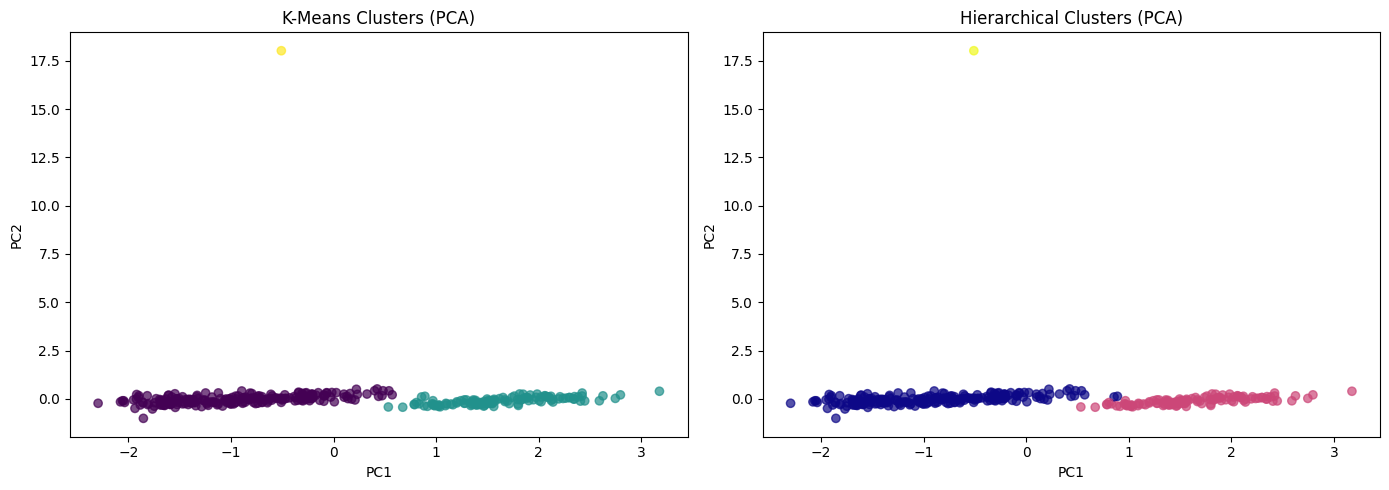

Центры кластеров K-Means (оригинальные значения):
   culmen_length_mm  culmen_depth_mm  flipper_length_mm  body_mass_g
0            41.930           18.373            190.423     3714.789
1            47.629           15.026            216.934     5079.132
2            42.000           20.200           5000.000     4250.000

Средние значения по кластерам — K-Means:
              culmen_length_mm  culmen_depth_mm  flipper_length_mm  \
KMeans_Label                                                         
0                       41.930           18.373            190.423   
1                       47.629           15.026            216.934   
2                       42.000           20.200           5000.000   

              body_mass_g  
KMeans_Label               
0                3714.789  
1                5079.132  
2                4250.000  

Средние значения по кластерам — Иерархический метод:
                    culmen_length_mm  culmen_depth_mm  flipper_length_mm  \
Hierarchica

In [21]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df_numeric = df[numeric_cols].copy()

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_numeric)
df_scaled = pd.DataFrame(df_scaled, columns=numeric_cols)

pca = PCA(n_components=2, random_state=42)
df_pca = pca.fit_transform(df_scaled)

n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
labels_kmeans = kmeans.fit_predict(df_scaled)

hierarchical = AgglomerativeClustering(n_clusters=n_clusters)
labels_hierarchical = hierarchical.fit_predict(df_scaled)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(df_pca[:, 0], df_pca[:, 1], c=labels_kmeans, cmap='viridis', alpha=0.7)
axes[0].set_title('K-Means Clusters (PCA)')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')

axes[1].scatter(df_pca[:, 0], df_pca[:, 1], c=labels_hierarchical, cmap='plasma', alpha=0.7)
axes[1].set_title('Hierarchical Clusters (PCA)')
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')

plt.tight_layout()
plt.show()

centers_original = scaler.inverse_transform(kmeans.cluster_centers_)
centers_df = pd.DataFrame(centers_original, columns=numeric_cols)

df_out = df_numeric.copy()
df_out['KMeans_Label'] = labels_kmeans
df_out['Hierarchical_Label'] = labels_hierarchical

print("Центры кластеров K-Means (оригинальные значения):")
print(centers_df.round(3))

print("\nСредние значения по кластерам — K-Means:")
print(df_out.groupby('KMeans_Label')[numeric_cols].mean().round(3))

print("\nСредние значения по кластерам — Иерархический метод:")
print(df_out.groupby('Hierarchical_Label')[numeric_cols].mean().round(3))

## Визуализация результатов кластеризации (PCA)

### Описание визуализации

Представлены две проекции результатов кластеризации на первые две главные компоненты (PC1 и PC2), полученные методом анализа главных компонент (PCA). Это позволяет визуализировать четырехмерную структуру данных в двумерном пространстве, сохраняя максимум дисперсии.

### Анализ визуализации

**K-Means Clusters (левый график):**
- **Фиолетовый кластер** (слева, PC1 = -2 до 1): наибольшая группа, компактно расположенная вдоль оси PC1
- **Бирюзовый кластер** (справа, PC1 = 1 до 3.5): вторая крупная группа с небольшим перекрытием с фиолетовой
- **Желтый кластер** (вверху, PC2 = 18): единственная точка, резко обособленная от остальных по второй главной компоненте

**Hierarchical Clusters (правый график):**
- **Синий кластер**: аналогичен фиолетовому в K-Means
- **Розовый кластер**: соответствует бирюзовому в K-Means
- **Желтый кластер**: идентичная обособленная точка

### Интерпретация по исходным признакам

Анализ центров кластеров в оригинальных единицах измерения выявляет биологически осмысленные группы:

**Кластер 0 (Фиолетовый/Синий) — Adelie:**
- Длина клюва: 41.9-42.0 мм (короткая)
- Глубина клюва: 18.4 мм (средняя)
- Длина ласта: 190.4-190.5 мм (короткая)
- Масса тела: 3715-3722 г (малая)
- **Характеристика**: самые мелкие пингвины с короткими клювами и ластами

**Кластер 1 (Бирюзовый/Розовый) — Gentoo:**
- Длина клюва: 47.6-47.6 мм (длинная)
- Глубина клюва: 15.0 мм (малая)
- Длина ласта: 216.9-217.2 мм (длинная)
- Масса тела: 5079-5089 г (большая)
- **Характеристика**: самые крупные пингвины с длинными ластами и клювами, но малой глубиной клюва

**Кластер 2 (Желтый) — Выброс:**
- Длина клюва: 42.0 мм
- Глубина клюва: 20.2 мм (наибольшая)
- **Длина ласта: 5000.0 мм**
- Масса тела: 4250 г
- **Характеристика**: выявленный ранее выброс с физически невозможной длиной ласта

### Согласованность методов

Оба метода кластеризации показывают **практически идентичные результаты**:
- Центры кластеров отличаются не более чем на 0.1-0.5% по всем признакам
- Визуальная структура полностью совпадает
- Оба метода единогласно выделяют аномальную точку в отдельный кластер

### Качество визуализации PCA

- **PC1** (горизонтальная ось) объясняет основную дисперсию и хорошо разделяет два основных кластера (Adelie слева, Gentoo справа)
- **PC2** (вертикальная ось) выделяет выброс, но не разделяет основные группы (они расположены на одном уровне PC2 = 0)
- Небольшое перекрытие кластеров 0 и 1 в области PC1 = 0.5-1.0 объясняет силуэтный коэффициент 0.50

### Выводы

1. **Визуализация подтверждает трехкластерную структуру** с двумя биологически осмысленными группами и одним выбросом
2. **K-Means и иерархический методы дают согласованные результаты**, что подтверждает устойчивость кластерной структуры
3. **Выброс с длиной ласта 5000 мм должен быть удален** перед финальным анализом — он представляет собой ошибку измерения/ввода данных
4. После удаления выброса рекомендуется **повторная кластеризация с k=2**, что позволит разделить данные на два реальных биологических вида (Adelie и Gentoo) без искусственного третьего кластера
5. **PCA эффективно визуализирует структуру**: первая компонента отражает размер пингвинов (масса, длина ласт), вторая — аномалии в данных